In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
import collections

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.metrics import roc_auc_score, accuracy_score, auc
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve

pd.options.mode.chained_assignment = None 
from torch.utils.data import Dataset


from base.base_dataset import BaseADDataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from deepSVDD import DeepSVDD

In [5]:
def load_train_year(year):
    if year <= 2010:
        df = pd.read_parquet(f'../../datasets/Kyoto-2016_AnoShift/subset/{year}_subset.parquet',  engine='fastparquet')
    else:
        import sys
        sys.exit(-1)
    df = df.reset_index(drop=True)
    return df

def load_test_year(year):
    if year <= 2010:
        df = pd.read_parquet(f'../../datasets/Kyoto-2016_AnoShift/subset/{year}_subset_valid.parquet',  engine='fastparquet')
    else:
        df = pd.read_parquet(f'../../datasets/Kyoto-2016_AnoShift/subset/{year}_subset.parquet',  engine='fastparquet')

    df = df.reset_index(drop=True)
    return df

def rename_columns(df):    
    categorical_cols = ["0", "1", "2", "3", "13"]
    numerical_cols = ["4", "5", "6", "7", "8", "9", "10", "11", "12"]
    additional_cols = ["14", "15", "16", "17", "19"]
    label_col = ["18"]

    new_names = []
    for col_name in df.columns.astype(str).values:
        if col_name in numerical_cols:
            df[col_name] = pd.to_numeric(df[col_name])
            new_names.append((col_name, "num_" + col_name))
        elif col_name in categorical_cols:
            new_names.append((col_name, "cat_" + col_name))
        elif col_name in additional_cols:
            new_names.append((col_name, "bonus_" + col_name))
        elif col_name in label_col:
            df[col_name] = pd.to_numeric(df[col_name])
            new_names.append((col_name, "label"))
        else:
            new_names.append((col_name, col_name))
    df.rename(columns=dict(new_names), inplace=True)
    
    return df

def preprocess(df, enc=None):
    if not enc:
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(df.loc[:,['cat_' in i for i in df.columns]])
    
    num_cat_features = enc.transform(df.loc[:,['cat_' in i for i in df.columns]]).toarray()

    df_catnum = pd.DataFrame(num_cat_features)
    df_catnum = df_catnum.add_prefix('catnum_')

    df.reset_index(drop=True)
    df_new = pd.concat([df,  df_catnum], axis=1)
    
    
    filter_clear = df_new["label"] == 1
    filter_infected = df_new["label"] < 0
    df_new["label"][filter_clear] = 0
    df_new["label"][filter_infected] = 1

    return df_new


def print_results(labels, preds, text="?", normalize="true", th=0.5):
    precision_anom, recall_anom, th_anom = precision_recall_curve(labels, preds, pos_label=1)
    precision_norm, recall_norm, th_norm = precision_recall_curve(labels, 1-np.array(preds), pos_label=0)
    
    prec, recall, _, _ = precision_recall_fscore_support(labels, np.array(preds)>=th)
    
    # Use AUC function to calculate the area under the curve of precision recall curve
    pr_auc_norm = auc(recall_norm, precision_norm)
    pr_auc_anom = auc(recall_anom, precision_anom)
    
    roc_auc = roc_auc_score(labels, preds)
    
    print("[%s] ROC-AUC     %.2f%% | PR-AUC-norm    %.2f%% | PR-AUC-anom    %.2f%%" % (text, roc_auc*100, pr_auc_norm*100, pr_auc_anom*100))
    return roc_auc*100, pr_auc_norm*100, pr_auc_anom*100

In [6]:
class MyDataset(Dataset):
    def __init__(self, df_year, ohe_enc):
        df_year = preprocess(df_year, ohe_enc)
        numerical_cols = df_year.columns.to_numpy()[['num_' in i for i in df_year.columns]]

        x = df_year[numerical_cols].iloc[:,:-1].values
        y = df_year["label"].values

        self.x_train = torch.tensor(x, dtype=torch.float32)
        self.targets = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.x_train.shape[0]

    def __getitem__(self,idx):
        return self.x_train[idx],self.targets[idx], idx

In [7]:
# Instantiate distance
train_years = list(range(2006, 2011, 1))
test_years = list(range(2006, 2016, 1))


df_test_years = []
df_train_years = []
cats = []

for year in train_years:
    df_year = rename_columns(load_train_year(year))
    print("train year", year, df_year.shape)
    cat = df_year.loc[:,['cat_' in i for i in df_year.columns]]
    
    df_train_years.append(df_year)
    cats.append(cat)

# enc only on train data
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(pd.concat(cats, axis=0))
    
for year in test_years:
    df_year = rename_columns(load_test_year(year))
    print("test year", year, df_year.shape)
    cat = df_year.loc[:,['cat_' in i for i in df_year.columns]]
    
    df_test_years.append(df_year)
    cats.append(cat)


train year 2006 (466774, 20)
train year 2007 (415471, 20)
train year 2008 (374713, 20)
train year 2009 (409403, 20)
train year 2010 (561262, 20)
test year 2006 (280064, 20)
test year 2007 (41547, 20)
test year 2008 (37471, 20)
test year 2009 (40940, 20)
test year 2010 (56126, 20)
test year 2011 (1119249, 20)
test year 2012 (934592, 20)
test year 2013 (1538064, 20)
test year 2014 (2122662, 20)
test year 2015 (2104323, 20)


In [ ]:
scaler = RobustScaler()
train_datasets = []
for_scaler = []

for i_year, year in enumerate(train_years):
    df_year = df_train_years[i_year]
    ds = MyDataset(df_year, enc)
    for_scaler.append(ds.x_train)
    train_datasets.append(ds)

scaler.fit(np.concatenate(for_scaler, axis=0))

for i_year, year in enumerate(train_years):
    train_datasets[i_year].x_train = torch.tensor(scaler.transform(train_datasets[i_year].x_train), dtype=torch.float32)
    
train_dataset = ConcatDataset(train_datasets)


In [ ]:
class KyotoDataset(BaseADDataset):
    def __init__(self, root, train_set, test_set):
        super().__init__(root)
        self.train_set = train_set
        self.test_set = test_set

    def loaders(self, batch_size: int, shuffle_train=True, shuffle_test=False, num_workers: int = 0) -> (
            DataLoader, DataLoader):
        train_loader = DataLoader(dataset=self.train_set, batch_size=batch_size, shuffle=shuffle_train,
                                  num_workers=num_workers)
        test_loader = DataLoader(dataset=self.test_set, batch_size=batch_size, shuffle=shuffle_test,
                                 num_workers=num_workers)
        return train_loader, test_loader
    

In [ ]:
kyoto_train_ds = KyotoDataset("", train_dataset, train_dataset)

In [ ]:
device = "cuda"
n_jobs_dataloader = 20
net_name = "kyoto"

nu = 0.2
n_epochs = 2

deep_SVDD = DeepSVDD("one-class", nu)
deep_SVDD.set_network(net_name)

# Train model on dataset
deep_SVDD.train(kyoto_train_ds,
                optimizer_name="adam",
                n_epochs=n_epochs,
                batch_size=10000,
                device=device,
                n_jobs_dataloader=n_jobs_dataloader)

rocs, pr_norms, pr_anoms = [], [], []
for i_year, year in enumerate(test_years):
    df_year = df_test_years[i_year]
    test_dataset = MyDataset(df_year, enc)
    test_dataset.x_train = torch.tensor(scaler.transform(test_dataset.x_train), dtype=torch.float32)
    kyoto_test_ds = KyotoDataset("", test_dataset, test_dataset)

    deep_SVDD.test(kyoto_test_ds, device=device, n_jobs_dataloader=n_jobs_dataloader)

    # Plot most anomalous and most normal (within-class) test samples
    indices, labels, scores = zip(*deep_SVDD.results['test_scores'])
    indices, labels, scores = np.array(indices), np.array(labels), np.array(scores)

    roc, pr_norm, pr_anom = print_results(labels, scores/scores.max(), text="deepSVDD " + str(year), th=0.05, normalize=None)
    rocs.append(roc)
    pr_norms.append(pr_norm)
    pr_anoms.append(pr_anom)


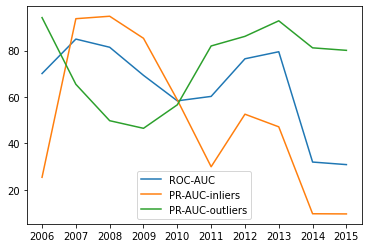

In [37]:
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.plot(test_years, rocs, label='ROC-AUC')
plt.plot(test_years, pr_norms, label='PR-AUC-inliers')
plt.plot(test_years, pr_anoms, label='PR-AUC-outliers')
plt.legend()
plt.show()